## Rover Project Test Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()


## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

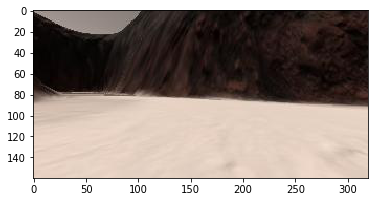

In [3]:
PATH = '../test_dataset/IMG/*'
IMG_LIST = glob.glob(PATH)
IMAGE = mpimg.imread(np.random.choice(IMG_LIST))
plt.imshow(IMAGE)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

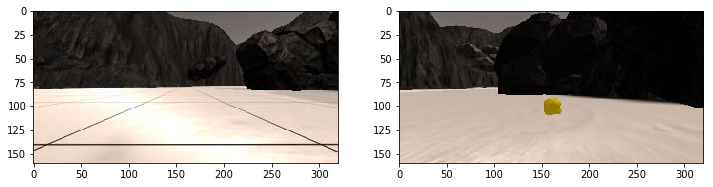

In [4]:
# Here's an example of the grid and one of the rocks
plt.figure(figsize=(12,3))

IMAGE_GRID = mpimg.imread('../calibration_images/example_grid1.jpg')
plt.subplot(121)
plt.imshow(IMAGE_GRID)

plt.subplot(122)
plt.imshow(mpimg.imread('../calibration_images/example_rock1.jpg'))

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

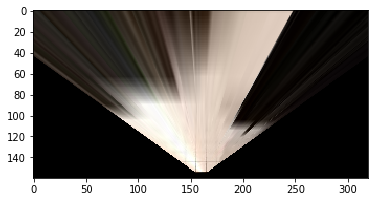

In [5]:
PIXELS_PER_METER = 10.0
BOTTOM_OFFSET = 6
IMAGE_H, IMAGE_W = IMAGE.shape[:2]

POINTS_PERSPECTIVE = np.float32([
    [14, 140],
    [301 ,140],
    [200, 96],
    [118, 96]
])

POINTS_TOP = np.float32([
    [0.5 * (IMAGE_W - PIXELS_PER_METER), IMAGE_H - BOTTOM_OFFSET],
    [0.5 * (IMAGE_W + PIXELS_PER_METER), IMAGE_H - BOTTOM_OFFSET],
    [0.5 * (IMAGE_W + PIXELS_PER_METER), IMAGE_H - PIXELS_PER_METER - BOTTOM_OFFSET], 
    [0.5 * (IMAGE_W - PIXELS_PER_METER), IMAGE_H - PIXELS_PER_METER - BOTTOM_OFFSET]
])

PERSPECTIVE_2_TOP = cv2.getPerspectiveTransform(POINTS_PERSPECTIVE, POINTS_TOP)


def perspective_2_top(img):

    warped = cv2.warpPerspective(
        img,
        PERSPECTIVE_2_TOP,
        (img.shape[1], img.shape[0]))# keep same size as input image   

    return warped


plt.imshow(perspective_2_top(IMAGE_GRID))

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**TODO:** Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for.  Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.  
**Hints and Suggestion:** 
* For obstacles you can just invert your color selection that you used to detect ground pixels, i.e., if you've decided that everything above the threshold is navigable terrain, then everthing below the threshold must be an obstacle!


* For rocks, think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors.  You can investigate the colors of the rocks (the RGB pixel values) in an interactive matplotlib window to get a feel for the appropriate threshold range (keep in mind you may want different ranges for each of R, G and B!).  Feel free to get creative and even bring in functions from other libraries.  Here's an example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  

* **Beware However:** if you start manipulating images with OpenCV, keep in mind that it defaults to `BGR` instead of `RGB` color space when reading/writing images, so things can get confusing.

### Confidence Map

Instead of naive binary thresholding, let us extract log-likelihood local confidence maps from the image in the perspective view, transform it into the bird-eye view, and add it to the global confidence map.

Instead of manual adjustment of threshold parameters, the probability distributions are extracted from two labelled images with GaussianMixture or GaussianNB machine learning algorithms from sklearn library.

There will be two global confidence maps: one for evaluating the probability of the navigation area; another one evaluating the probability of rocks. Each pixel of each global confidence map will hold a log-likelihood of binomial distribution.

\begin{equation*}
\ln{\frac{p}{1-p}}
\end{equation*}

This will allow to naturally deal with uncovered and distant pixels in the top view. Probabilities of uncovered pixels will be 0.5, meaning there is no information available for them. Probabilities of distant pixels will become closer to 0.5. Log-likelihoods of 0.5 probabilities will be zero, thus not contributing any information to the global confidence map.

\begin{equation*}
\ln{\frac{0.5}{1-0.5}}=\ln{1.0}=0
\end{equation*}

A global confidence map holds a log-likelihood probability that a pixel belongs to a particular class. For example, for the navigatable class, each pixel value will mean as follows:

\begin{equation*}
\ln{\frac{p(navigatable)}{1-p(navigatable)}}=\ln{\frac{p(navigatable)}{p(obstacle)}}
\end{equation*}

In order to update a global confidence map, two local confidence maps are used. Each local confidence map holds the probability that a given color was generated by a particular class: ln p(color|navigatable) and ln p(color|obstacle). Local confidence maps are generated by machine learning algorithms.

The Bayes formula is used to update a global confidence map:

\begin{equation*}
p(navigatable|rgb)=\frac{p(rgb|navigatable)*p(navigatable)}{p(rgb)}
\end{equation*}

It can be adopted to deal with probability ratios:

\begin{equation*}
\frac{p(navigatable|rgb)}{1.0-p(navigatable|rgb)}=\frac{p(rgb|navigatable)*p(navigatable)}{p(rgb|obstacle)*(1.0 - p(navigatable))}
\end{equation*}

The logarithms allows to replace multiplications and divisions with addition and subtractions:

\begin{equation*}
\ln{\frac{p(navigatable|rgb)}{1.0-p(navigatable|rgb)}}=\ln{p(rgb|navigatable)}-\ln{p(rgb|obstacle)}+\ln{\frac{p(navigatable)}{1.0 - p(navigatable)}}
\end{equation*}

This results in the following update formula for the global confidence map pixels:

global_map += ln p(rgb|navigatable) - ln p(rgb|obstacle)

or, equivalently,

global_map += local_map_navigatable - local_map_obstacle

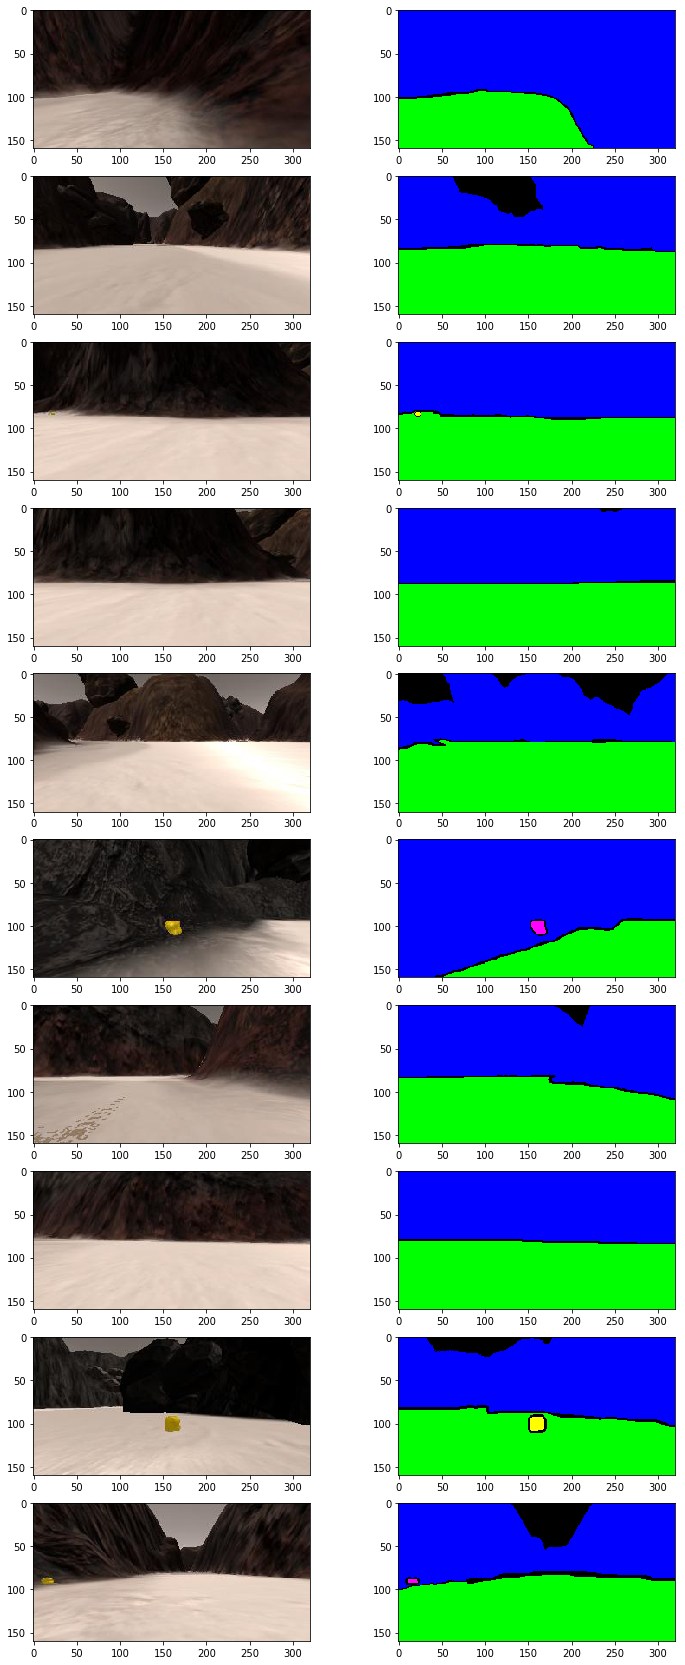

In [6]:
# Labelled images to train color classifiers

def training_samples():
    masks = glob.glob('../calibration_images/*_mask.png')
    
    result = []
    for mask in masks:
        img_path = mask.replace("_mask.png", ".jpg")
        img = mpimg.imread(img_path)
        label_img = mpimg.imread(mask)
        
        result.append((img, label_img))

    return result

TRAINING_SAMPLES = training_samples()

plt.figure(figsize=(12, len(TRAINING_SAMPLES) * 3))

for index, (img, label_img) in enumerate(TRAINING_SAMPLES):
    plt.subplot(len(TRAINING_SAMPLES), 2, 1 + index * 2)
    plt.imshow(img)
    
    plt.subplot(len(TRAINING_SAMPLES), 2, 2 + index * 2)
    plt.imshow(label_img)

In [7]:
# Prepare training data

from sklearn.utils import shuffle

NON_EMPTY = np.concatenate(
    [np.logical_or(
        y[:,:,0] != 0,
        np.logical_or(
            y[:,:,1] != 0,
            y[:,:,2] != 0)).ravel() for _, y in TRAINING_SAMPLES])

TRAINING_X = np.concatenate([
    x.reshape(-1, 3) for x, _ in TRAINING_SAMPLES])

TRAINING_ROCKS = np.concatenate([
    (y[:, :, 0] != 0).reshape(-1) for _, y in TRAINING_SAMPLES])

TRAINING_NAVI = np.concatenate([
    (y[:, :, 1] != 0).reshape(-1) for _, y in TRAINING_SAMPLES])

TRAINING_X, TRAINING_ROCKS, TRAINING_NAVI = shuffle(
    TRAINING_X[NON_EMPTY],
    TRAINING_ROCKS[NON_EMPTY],
    TRAINING_NAVI[NON_EMPTY],
    random_state=0)

print("Number of Training Samples:", len(TRAINING_X))

Number of Training Samples: 489441


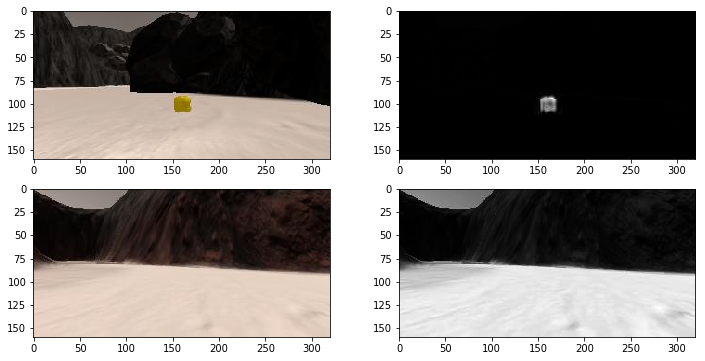

In [8]:
# Prepare color classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture


class ClassifierNavi:
    def __init__(self):    
        self.__cls = GaussianNB()
        self.__cls.fit(TRAINING_X, TRAINING_NAVI)

        
    def predict(self, img):
        scores = self.__cls.predict_log_proba(img.reshape(-1, 3))
        return (scores[:, 1] - scores[:, 0]).reshape(img.shape[:2])
    
    
class ClassifierRocks:
    def __init__(self):
        x = TRAINING_X
        y = TRAINING_ROCKS
        self.__cls = GaussianMixture(random_state=0).fit(x[y])
        
        # There are two Gaussians for background pixels expected: one belongs
        # to the dark mountains and another to the sand pixels
        means_init = np.array([[0.0, 0.0, 0.0], [255.0, 255.0, 255.0]])
        self.__not_cls = GaussianMixture(2, random_state=0, means_init=means_init)
        self.__not_cls.fit(x[~y])
        

    def predict(self, img):
        x = img.reshape(-1, 3)

        #
        # Here we are subtracting logarithms of probability densities, not probabilities
        # However, the result should be very similar as if we dealt with probabilities
        # 
        # probability = integral(probability_density, [a, b]), which is approximately
        # equal to (b - a) * probability_density if we assume that probability_density
        # is approximately constant on some small interval [a, b]
        #
        # The multiplier (b - a) becomes a separate logarithm, which is the same for
        # two terms, and it is cancelled out:
        #
        # log((b - a) * probability_density_cls)
        # - log((b - a) * probability_density_not_cls)
        #
        # =>
        #
        # log(b - a)
        # + log(probability_density_cls)
        # - log(b - a)
        # - log(probability_density_not_cls)
        #
        # =>
        #
        # log(probability_density_cls) - log(probability_density_not_cls)
        #
        s = self.__cls.score_samples(x) - self.__not_cls.score_samples(x)
        return s.reshape(img.shape[:2])
     

CLASSIFIER_ROCKS = ClassifierRocks()
CLASSIFIER_NAVI = ClassifierNavi()

IMAGE_ROCK1 = mpimg.imread('../calibration_images/example_rock1.jpg')

plt.figure(figsize=(12, 6))
plt.subplot(221)
plt.imshow(IMAGE_ROCK1)

plt.subplot(222)
plt.imshow(CLASSIFIER_ROCKS.predict(IMAGE_ROCK1), cmap='gray')

plt.subplot(223)
plt.imshow(IMAGE)

plt.subplot(224)
plt.imshow(CLASSIFIER_NAVI.predict(IMAGE), cmap='gray')

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

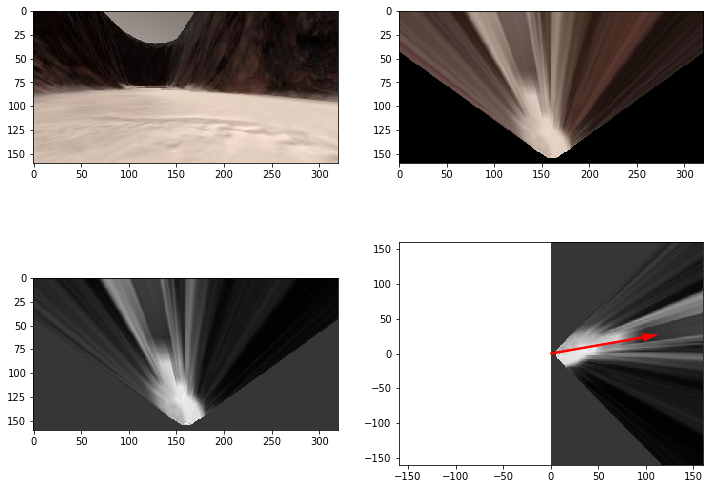

In [9]:
LOCAL_2_ROVER = np.array([
    [0.0, -1.0, IMAGE_H],
    [-1.0, 0.0, IMAGE_W * 0.5]],
    np.float32)


# Calculate transformation 2x3 affine transformation matrix
# From local confidence map into global confidence map reference frames
def local_2_global(xpos, ypos, yaw_deg):
    yaw_rad = yaw_deg * np.pi / 180
    c_scaled = np.cos(yaw_rad) / PIXELS_PER_METER
    s_scaled = np.sin(yaw_rad) / PIXELS_PER_METER
    
    local_2_rover_3x3 = np.vstack([LOCAL_2_ROVER, [0.0, 0.0, 1.0]])
    
    rover_2_global = np.array([
        [c_scaled, -s_scaled, xpos],
        [s_scaled, c_scaled, ypos]],
        np.float32)  

    return rover_2_global.dot(local_2_rover_3x3)


IMG_ROWS, IMG_COLS = np.indices((IMAGE_H, IMAGE_W))
IMG_ROWS = IMG_ROWS.ravel()
IMG_COLS = IMG_COLS.ravel()
IMG_ONES = np.ones_like(IMG_COLS)

LOCAL_CONF_POINTS = np.vstack([IMG_COLS, IMG_ROWS, IMG_ONES]).astype(np.float32).T

ROVER_CONF_POINTS = LOCAL_2_ROVER.dot(LOCAL_CONF_POINTS.T).T

ROVER_CONF_DIRS = ROVER_CONF_POINTS / np.linalg.norm(ROVER_CONF_POINTS, axis=1).reshape(-1, 1)
np.nan_to_num(ROVER_CONF_DIRS, False)


def navi_direction(navi_top_view, distract_from_walls):
    values = navi_top_view.reshape(-1, 1)
    dirs = ROVER_CONF_DIRS
    
    if not distract_from_walls:
        values = np.copy(values)
        values[values < 0] = 0
    
    v = np.mean(dirs * values, axis=0)
    v /= np.linalg.norm(v)
    np.nan_to_num(v, False)
    return v


# Grab another random image
IMAGE2 = mpimg.imread(np.random.choice(IMG_LIST))
IMAGE2_NAVI = CLASSIFIER_NAVI.predict(IMAGE2)
IMAGE2_NAVI_TOP_VIEW = perspective_2_top(IMAGE2_NAVI)

# Calculate recommended navigation direction
IMAGE2_NAVI_DIR = navi_direction(IMAGE2_NAVI_TOP_VIEW, False)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(IMAGE2)
plt.subplot(222)
plt.imshow(perspective_2_top(IMAGE2))
plt.subplot(223)
plt.imshow(IMAGE2_NAVI_TOP_VIEW, cmap='gray')
plt.subplot(224)

plt.ylim(-160, 160)
plt.xlim(-160, 160)

plt.pcolor(
    ROVER_CONF_POINTS[:, 0].reshape(IMAGE2_NAVI_TOP_VIEW.shape),
    ROVER_CONF_POINTS[:, 1].reshape(IMAGE2_NAVI_TOP_VIEW.shape),
    IMAGE2_NAVI_TOP_VIEW,
    cmap='gray')
    
plt.arrow(
    0,
    0,
    IMAGE2_NAVI_DIR[0] * 100,
    IMAGE2_NAVI_DIR[1] * 100,
    color='red',
    zorder=2,
    head_width=10,
    width=2)

## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [10]:
# Import pandas and read in csv file as a dataframe
import pandas as pd

# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
ROBOT_LOG = pd.read_csv(
    '../test_dataset/robot_log.csv',
    delimiter=';',
    decimal='.')

CSV_IMG_LIST = ROBOT_LOG["Path"].tolist() # Create list of image pathnames

# Read in ground truth map and create a 3-channel image with it
GROUND_TRUTH = mpimg.imread('../calibration_images/map_bw.png')

GROUND_TRUTH_3D = np.dstack((
    GROUND_TRUTH*0,
    GROUND_TRUTH*255,
    GROUND_TRUTH*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = CSV_IMG_LIST
        self.xpos = ROBOT_LOG["X_Position"].values
        self.ypos = ROBOT_LOG["Y_Position"].values
        self.yaw = ROBOT_LOG["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.global_conf_rocks = np.zeros((200, 200)).astype(np.float)
        self.global_conf_rocks_cur = np.zeros((200, 200)).astype(np.float)
        self.global_conf_navi = np.zeros((200, 200)).astype(np.float)
        self.global_conf_navi_cur = np.zeros((200, 200)).astype(np.float)
        self.ground_truth = GROUND_TRUTH_3D # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
DATA = Databucket()


## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [11]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    xpos = DATA.xpos[DATA.count]
    ypos = DATA.ypos[DATA.count]
    yaw_deg = DATA.yaw[DATA.count]
    
    loc_2_glob = local_2_global(xpos, ypos, yaw_deg)
    
    rocks = CLASSIFIER_ROCKS.predict(img)
    rocks_top = perspective_2_top(rocks)
    DATA.global_conf_rocks_cur.fill(0)
    
    cv2.warpAffine(
        rocks_top,
        loc_2_glob,
        (DATA.global_conf_rocks_cur.shape[1], DATA.global_conf_rocks_cur.shape[0]),
        DATA.global_conf_rocks_cur)
    
    # Clipping to prevent the map from being overconfident
    DATA.global_conf_rocks = np.clip(
        DATA.global_conf_rocks + DATA.global_conf_rocks_cur,
        -255.0,
        255.0)
    
    navi = CLASSIFIER_NAVI.predict(img)
    navi_top = perspective_2_top(navi)
        
    DATA.global_conf_navi_cur.fill(0)
    
    cv2.warpAffine(
        navi_top,
        loc_2_glob,
        (DATA.global_conf_navi_cur.shape[1], DATA.global_conf_navi_cur.shape[0]),
        DATA.global_conf_navi_cur)
      
    # Clipping to prevent the map from being overconfident
    DATA.global_conf_navi = np.clip(
        DATA.global_conf_navi + DATA.global_conf_navi_cur,
        -255.0,
        255.0)
    
    rocks_mask = DATA.global_conf_rocks > 0
    
    DATA.worldmap[:, :, 0] = np.maximum(
        255 * rocks_mask,
        -DATA.global_conf_navi * (DATA.global_conf_navi < 0))

    DATA.worldmap[:, :, 1] = 255 * rocks_mask

    DATA.worldmap[:, :, 2] = np.maximum(
        255 * rocks_mask,
        DATA.global_conf_navi * (DATA.global_conf_navi > 0))
    
    output_image = np.zeros((img.shape[0] + DATA.worldmap.shape[0], img.shape[1]*2, 3))
    output_image[0:img.shape[0], 0:img.shape[1]] = img
    output_image[0:img.shape[0], img.shape[1]:] = perspective_2_top(img)

    map_add = cv2.addWeighted(DATA.worldmap, 1, DATA.ground_truth, 0.5, 0)
    output_image[img.shape[0]:, 0:DATA.worldmap.shape[1]] = np.flipud(map_add)

    if DATA.count < len(DATA.images) - 1:
        DATA.count += 1
    
    return output_image

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
OUTPUT = '../output/test_mapping.mp4'
DATA = Databucket() # Re-initialize data in case you're running this cell multiple times
CLIP = ImageSequenceClip(DATA.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
NEW_CLIP = CLIP.fl_image(process_image) #NOTE: this function expects color images!!
%time NEW_CLIP.write_videofile(OUTPUT, audio=False)

[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4


100%|██████████| 1058/1058 [00:28<00:00, 37.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping.mp4 

CPU times: user 26.6 s, sys: 1.49 s, total: 28.1 s
Wall time: 28.3 s


### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [13]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(OUTPUT))

### Below is an alternative way to create a video in case the above cell did not work.

In [14]:
import io
import base64
VIDEO = io.open(OUTPUT, 'r+b').read()
ENCODED_VIDEO = base64.b64encode(VIDEO)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(ENCODED_VIDEO.decode('ascii')))